In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import optuna

In [2]:
train_df = pd.read_csv('Train (2).csv')
test_df = pd.read_csv('test (2).csv')
sub_df = pd.read_csv('SampleSubmission.csv')

In [3]:
train_df

,ID,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,device_name,CO2
0,ID_000001,28.975,74.475,2480.0,3476.5,1572.0,1997.0,alpha,585.75
1,ID_000002,31.900,66.500,3813.0,2726.0,4145.0,3180.0,alpha,613.00
2,ID_000003,31.675,60.015,2811.0,1563.5,4250.0,2708.5,alpha,616.50
3,ID_000004,31.580,59.220,2844.0,1597.0,4310.0,2723.0,alpha,642.50
4,ID_000005,31.690,62.030,3159.5,1120.5,5519.5,1219.0,alpha,622.00
...,...,...,...,...,...,...,...,...,...
7302,ID_007303,30.285,64.640,5555.5,5483.5,4599.5,4190.0,charlie,604.00
7303,ID_007304,28.155,68.780,6128.5,5699.0,4720.0,4413.5,charlie,641.50
7304,ID_007305,27.950,69.550,5867.0,5515.0,4578.5,4244.0,charlie,638.50
7305,ID_007306,28.620,71.740,5888.5,5756.0,4697.0,4407.0,charlie,602.00


In [4]:
test_df.head()

,ID,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,device_name
0,ID_007308,32.450,59.990,3504.0,1380.0,2642.5,1637.0,alpha
1,ID_007309,31.665,58.640,2864.0,1659.0,4456.0,3564.5,alpha
2,ID_007310,31.755,59.000,2850.5,1615.0,4391.0,2683.5,alpha
3,ID_007311,31.860,66.850,3853.5,2868.5,4170.5,3025.5,alpha
4,ID_007312,29.600,73.115,2506.5,3631.5,1481.5,2112.5,alpha


In [5]:
#Feature engineering
for df in [train_df, test_df]:
    df['Total_reading'] = df['MQ7_analog'] + df['MQ9_analog'] + df['MG811_analog'] + df['MQ135_analog']
    df['MQ7_Ratio'] = df['MQ7_analog'] / df['Total_reading']
    df['MQ9_ratio'] = df['MQ9_analog'] / df['Total_reading']
    df['MG811_ratio'] = df['MG811_analog'] / df['Total_reading']
    df['MQ135_ratio'] = df['MQ135_analog'] / df['Total_reading']
    df['Temp_Humid'] = df['Temperature'] * df['Humidity']
    df['Temp_squared'] = df['Temperature'] ** 2
    df['Humid_squared'] = df['Humidity'] ** 2

In [6]:
# Exploratory Data Analysis
print("Train Data Info:\n")
train_df.info()

Train Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7307 entries, 0 to 7306
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             7307 non-null   object 
 1   Temperature    7307 non-null   float64
 2   Humidity       7307 non-null   float64
 3   MQ7_analog     7307 non-null   float64
 4   MQ9_analog     7307 non-null   float64
 5   MG811_analog   7307 non-null   float64
 6   MQ135_analog   7307 non-null   float64
 7   device_name    7307 non-null   object 
 8   CO2            7307 non-null   float64
 9   Total_reading  7307 non-null   float64
 10  MQ7_Ratio      7307 non-null   float64
 11  MQ9_ratio      7307 non-null   float64
 12  MG811_ratio    7307 non-null   float64
 13  MQ135_ratio    7307 non-null   float64
 14  Temp_Humid     7307 non-null   float64
 15  Temp_squared   7307 non-null   float64
 16  Humid_squared  7307 non-null   float64
dtypes: float64(15), object(2)
memory u

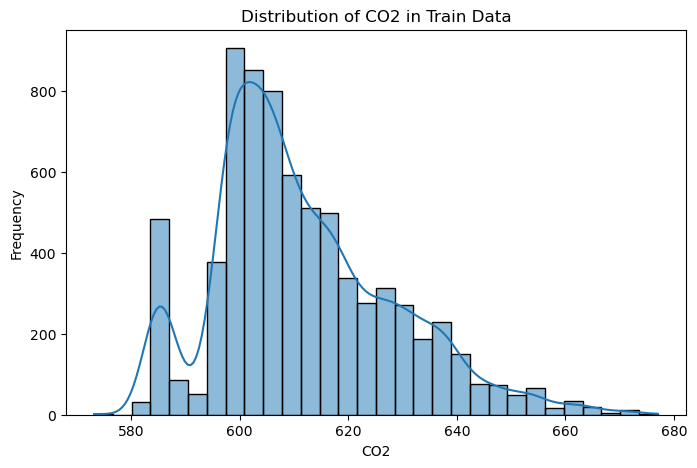

In [7]:
# Distribution of target variable
plt.figure(figsize=(8, 5))
sns.histplot(train_df['CO2'], kde=True, bins=30)
plt.title('Distribution of CO2 in Train Data')
plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.show()


In [8]:
# Feature selection and preprocessing
features = ['Temperature', 'Humidity', 'MQ7_analog', 'MQ9_analog', 'MG811_analog', 'MQ135_analog', 'device_name', 'Total_reading', 'MQ7_Ratio', 'MQ9_ratio', 'MG811_ratio', 'MQ135_ratio', 'Temp_Humid', 'Temp_squared', 'Humid_squared']
target = 'CO2'

In [9]:
#Separating Dependent variable & Independent Variable
X = train_df[features]
y = train_df[target]

In [10]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
#preprocessing pipeline

numeric_features = [col for col in X.columns if col != 'device_name']
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'),['device_name'])
    ],
    remainder='passthrough'
)

In [12]:
#Modelling and Hyperparameter tuning

def objective(trial):
    params = {  
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': True,
        'n_jobs': -1,
        'random_state': 42
    }
    
    model = RandomForestRegressor(**params) 
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor), 
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    return np.sqrt(mean_squared_error(y_val, y_pred))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2025-02-02 00:57:30,462] A new study created in memory with name: no-name-abf479ee-00a6-4405-9652-08d1984e6397


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-02 00:57:35,905] Trial 0 finished with value: 5.167183130583705 and parameters: {'n_estimators': 1113, 'max_depth': 54, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 5.167183130583705.
[I 2025-02-02 00:57:37,524] Trial 1 finished with value: 5.5242912629928105 and parameters: {'n_estimators': 373, 'max_depth': 36, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 5.167183130583705.
[I 2025-02-02 00:57:46,306] Trial 2 finished with value: 5.188227699413493 and parameters: {'n_estimators': 1811, 'max_depth': 40, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 5.167183130583705.
[I 2025-02-02 00:57:52,392] Trial 3 finished with value: 5.192397673951789 and parameters: {'n_estimators': 1234, 'max_depth': 41, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 5.16718313058370

[I 2025-02-02 01:01:00,968] Trial 33 finished with value: 4.9438719316531055 and parameters: {'n_estimators': 1005, 'max_depth': 76, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 28 with value: 4.831842582225742.
[I 2025-02-02 01:01:08,840] Trial 34 finished with value: 5.05423298464584 and parameters: {'n_estimators': 1315, 'max_depth': 55, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 28 with value: 4.831842582225742.
[I 2025-02-02 01:01:19,580] Trial 35 finished with value: 4.9908456881089425 and parameters: {'n_estimators': 1724, 'max_depth': 70, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 28 with value: 4.831842582225742.
[I 2025-02-02 01:01:25,557] Trial 36 finished with value: 5.528481018050226 and parameters: {'n_estimators': 1144, 'max_depth': 78, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 28 with value: 4.8318425

[I 2025-02-02 01:05:46,698] Trial 66 finished with value: 4.893699930408711 and parameters: {'n_estimators': 1350, 'max_depth': 67, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 64 with value: 4.82980662862908.
[I 2025-02-02 01:05:53,863] Trial 67 finished with value: 5.283633353794459 and parameters: {'n_estimators': 1250, 'max_depth': 88, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 64 with value: 4.82980662862908.
[I 2025-02-02 01:06:05,154] Trial 68 finished with value: 4.941541587143956 and parameters: {'n_estimators': 1587, 'max_depth': 52, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 64 with value: 4.82980662862908.
[I 2025-02-02 01:06:14,902] Trial 69 finished with value: 4.912408032679187 and parameters: {'n_estimators': 1409, 'max_depth': 69, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 64 with value: 4.829806628629

[I 2025-02-02 01:13:12,916] Trial 99 finished with value: 4.944414976999596 and parameters: {'n_estimators': 1375, 'max_depth': 51, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 64 with value: 4.82980662862908.


In [13]:
# Best model training
best_params = study.best_params
final_model = RandomForestRegressor(**best_params)

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', final_model)
])

final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Temperature', 'Humidity',
                                                   'MQ7_analog', 'MQ9_analog',
                                                   'MG811_analog',
                                                   'MQ135_analog',
                                                   'Total_reading', 'MQ7_Ratio',
                                                   'MQ9_ratio', 'MG811_ratio',
                                                   'MQ135_ratio', 'Temp_Humid',
                                                   'Temp_squared',
                                                   'Humid_squared']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['device_name'])])),
                ('model',
                 RandomForestRegressor(max_depth=69, max_features='sqrt',
                                       min_samples_split=4,
                                       n_estimators=1184))])

In [14]:
#Evaluation
train_pred = final_pipeline.predict(X_train)
val_pred = final_pipeline.predict(X_val)

train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")

Training RMSE: 2.3123
Validation RMSE: 4.8416


In [16]:
#Testing
predictions = final_pipeline.predict(test_df)

In [17]:
sub_df.head()

,ID,CO2
0,ID_007308,0
1,ID_007309,0
2,ID_007310,0
3,ID_007311,0
4,ID_007312,0


In [18]:
sub_df['CO2'] = predictions
sub_df.head()

,ID,CO2
0,ID_007308,631.583469
1,ID_007309,649.536019
2,ID_007310,626.886597
3,ID_007311,629.274200
4,ID_007312,584.859763


In [19]:
sub_df.to_csv('submissionSOFT.csv', index=False)